<a href="https://colab.research.google.com/github/pachit97/Curso.Prep.Henry/blob/master/Copia_de_TP_Integrador_Consultor_BI_Henry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

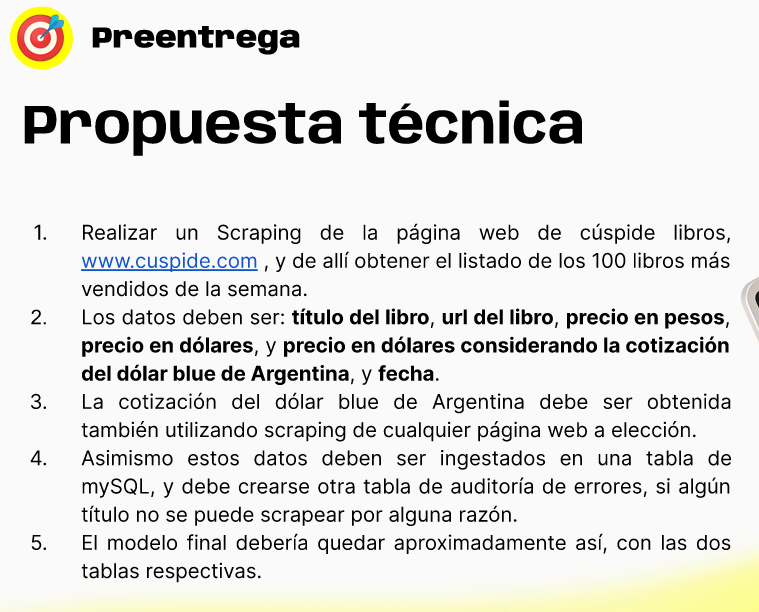

In [ ]:
#!pip install beautifulsoup4
#!pip install lxml

debug = True

In [ ]:
import requests
from bs4 import BeautifulSoup

URL = "https://www.cuspide.com/cienmasvendidos"

try:
  response = requests.get(URL, timeout=5)
  response.raise_for_status()  # Esto lanzará una excepción si el código de estado no es 200
except requests.Timeout:
  print("La solicitud excedió el tiempo máximo de espera.")
except requests.RequestException as e:
  print(f"Hubo un error al hacer la solicitud: {e}")

soup = BeautifulSoup(response.text, 'html.parser')
libros = []

for article in soup.find_all('article'): # Dentro de cada 'article', buscamos el enlace
  a_tag = article.find('a')
  url = a_tag['href']
  titulo = a_tag['title']
  # Añadimos la información a nuestra lista de libros
  libros.append({
        'titulo': titulo,
        'url': "https://www.cuspide.com" + url  # Añadimos la URL base para obtener la URL completa
    })


In [ ]:
if debug == True:
  # Imprimir el listado de Libros scrapeados
  print("\n".join(map(str, libros)))

In [ ]:
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import queue

# Función para limpiar y formatear el precio
def clean_price(price_str):
    price_str = re.sub(r'[^\d,]', '', price_str)
    price_float = float(price_str.replace(',', '.'))
    return round(price_float,2)

# Función para obtener el precio
def fetch_price(libro, q):
    try:
        response = requests.get(libro['url'], timeout=5)
        response.raise_for_status()
    except requests.Timeout:
        print("La solicitud excedió el tiempo máximo de espera.")
        q.put(1)
        return
    except requests.RequestException as e:
        print(f"Hubo un error al hacer la solicitud: {e}")
        q.put(1)
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    precio_container = soup.find('div', {'id': 'ctl00_ContentPlaceHolder1_rptFicha_ctl00_precioContainer'})

    if precio_container:
        precios = precio_container.find_all('div')
        precio_pesos = clean_price(precios[0].text)
        precio_dolares = clean_price(precios[1].text)
    else:
        precio_pesos = "Nada"
        precio_dolares = "Nada"

    # Agrega el precio en pesos y dólares al diccionario libro
    libro['precio_pesos'] = precio_pesos
    libro['precio_dolares'] = precio_dolares

    # Indicar que una tarea se completó
    q.put(1)

q = queue.Queue()
futures = []

with ThreadPoolExecutor(max_workers=10) as executor:
    for libro in libros:
        futures.append(executor.submit(fetch_price, libro, q))

    # Mostrar la barra de progreso
    for _ in tqdm(as_completed(futures), total=len(libros)):
        q.get()

100%|██████████| 96/96 [00:19<00:00,  4.87it/s]


In [ ]:
if debug == True:
  #Imprimir el listado de libros con su precio
  for libro in libros:
          print(f"Libro: {libro['titulo']}")
          print("Precio en pesos:", libro['precio_pesos'])
          print("Precio en dólares:", libro['precio_dolares'])

In [ ]:
#Cotización del dolar
import requests

urldolar = "https://dolarapi.com/v1/dolares/blue"
headers = {"Accept": "application/json"}
try:
  responsedolar = requests.get(urldolar,headers=headers, timeout=5)
  responsedolar.raise_for_status()
except responsedolar.Timeout:
  print("La solicitud excedió el tiempo máximo de espera.")
except responsedolar.RequestException as e:
  print(f"Hubo un error al hacer la solicitud: {e}")

datadolar = responsedolar.json()
precio_del_dolar_blue = int(datadolar["venta"])
if debug == True:
  print(precio_del_dolar_blue)

In [ ]:
# Calculo de precio en dolar blue y fecha

from datetime import datetime

# Obtener la fecha actual
fecha_actual = datetime.now()

# Formatear la fecha al formato deseado, por ejemplo: "2023-09-21"
fecha_formateada = fecha_actual.strftime('%Y-%m-%d')

for libro in libros:
  # Agregamos el precio calculado a dolar blue
  libro['precio_al_blue'] = round(libro['precio_pesos'] / precio_del_dolar_blue, 2)
  # Agregamos la fecha
  libro['fecha'] = fecha_formateada

In [ ]:
 if debug == True:
  # Mostrar elementos antes de cargarlo en la base de datos
  for libro in libros:
      for key, value in libro.items():
          print(f"{key}: {value}")
      print("----------")  # Esto es solo para separar cada libro visualmente


In [ ]:
import sqlite3

# Crear una base de datos en memoria (puedes cambiar ':memory:' por un nombre de archivo si deseas guardar la base de datos en un archivo)
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Crear una tabla para almacenar los datos de los libros
cursor.execute('''
CREATE TABLE libros (
    id INTEGER PRIMARY KEY,
    titulo TEXT,
    url TEXT,
    precio_pesos REAL,
    precio_dolar REAL,
    precio_dolar_blue REAL,
    fecha DATE
)
''')

# Insertar datos en la tabla
for libro in libros:
    cursor.execute('''
    INSERT INTO libros (titulo, url, precio_pesos, precio_dolar, precio_dolar_blue, fecha)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (libro['titulo'], libro['url'], libro['precio_pesos'], libro['precio_dolares'], libro['precio_al_blue'], libro['fecha']))

# Guardar los cambios
conn.commit()

In [ ]:
if debug == True:
  # (Opcional) Consultar la base de datos para verificar los datos
  cursor.execute('SELECT * FROM libros')
  for row in cursor.fetchall():
      print(row)


In [ ]:
# Cerrar la conexión / Borrar la DB de memoria
#conn.close()